In [1]:
import sys,os,random,torch,importlib,time
import torch.nn as nn
import wandb
import torch.distributed as dist
from omegaconf import OmegaConf
from pytorch_lightning.utilities.rank_zero import rank_zero_only

# Insert path for finding module (order: . -> ../../ -> ..)
sys.path.insert(1, os.path.abspath('..'))
sys.path.insert(1, os.path.abspath('../../'))
from utils.setup import init_path_and_expname,get_callbacks,get_logger,get_trainer_args
from datasets.unified_loader import get_loader
from criterions.criterion import MasterCriterion
from torchsummary import summary
import pytorch_lightning as pl
import numpy as np

In [2]:
cfg = OmegaConf.load(f'../configs/default.yaml')
cfg_cmd = OmegaConf.from_cli()
if "model" in cfg_cmd  and 'name' in cfg_cmd.model:
    cfg = OmegaConf.merge(cfg, OmegaConf.load(f'../configs/{cfg_cmd.model.name}.yaml'))
else:
    cfg = OmegaConf.merge(cfg, OmegaConf.load(f'../configs/{cfg.model.name}.yaml'))
cfg = OmegaConf.merge(cfg, cfg_cmd)

init_path_and_expname(cfg)
pl.seed_everything(cfg.seed)

Seed set to 160122


160122

In [3]:
# cfg.mode == 'test' for viusalization
dataloader = {
        'train': get_loader(cfg, 'train') if cfg.mode == 'train' else None,
        'valid': get_loader(cfg, 'valid') if cfg.mode == 'train' else None,
        'test' : get_loader(cfg, 'test') if cfg.mode == 'test' else None
    }

if cfg.mode == 'train':
    data = dataloader['valid']
elif cfg.mode == 'test':
    data = dataloader['test']

In [4]:
data_iter = iter(data)
for i in range(1):
    batch_dict = next(data_iter)

In [6]:
batch_dict = next(data_iter)

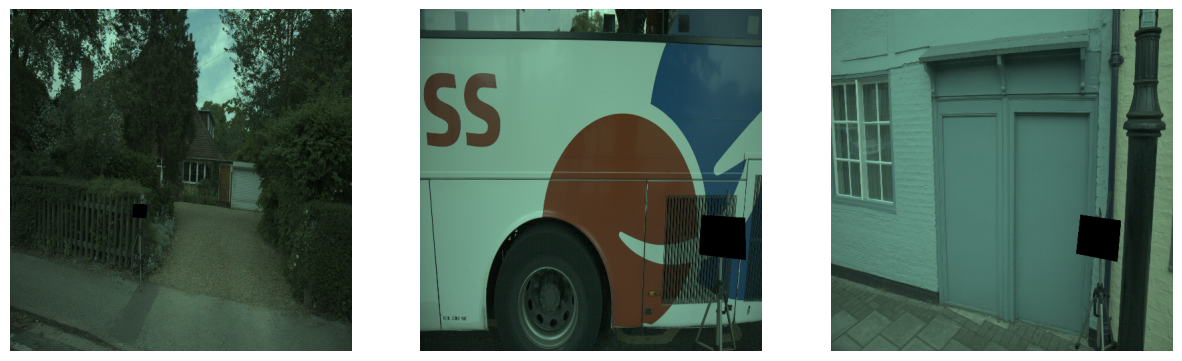

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    image = batch_dict['x'][i].permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

In [8]:
# Import model
network_mod = importlib.import_module(f'models.{cfg.model.name}_{cfg.model.ver}')  # import models/FC4_v1.py
network_class = getattr(network_mod, cfg.model.name)  # get class named "cfg.model.name"
network = network_class(cfg)

path = cfg.load.ckpt_path
ckpt = torch.load(path)
state_dict = ckpt['state_dict']
new_state_dict = {k.replace('net.', ''): v for k, v in state_dict.items()}
network.load_state_dict(new_state_dict)
network.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network.to(device)

images, illums = batch_dict['x'], batch_dict['y']
images, illums = images.to(device), illums.to(device)

with torch.no_grad():
    ret_dict = network(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for 

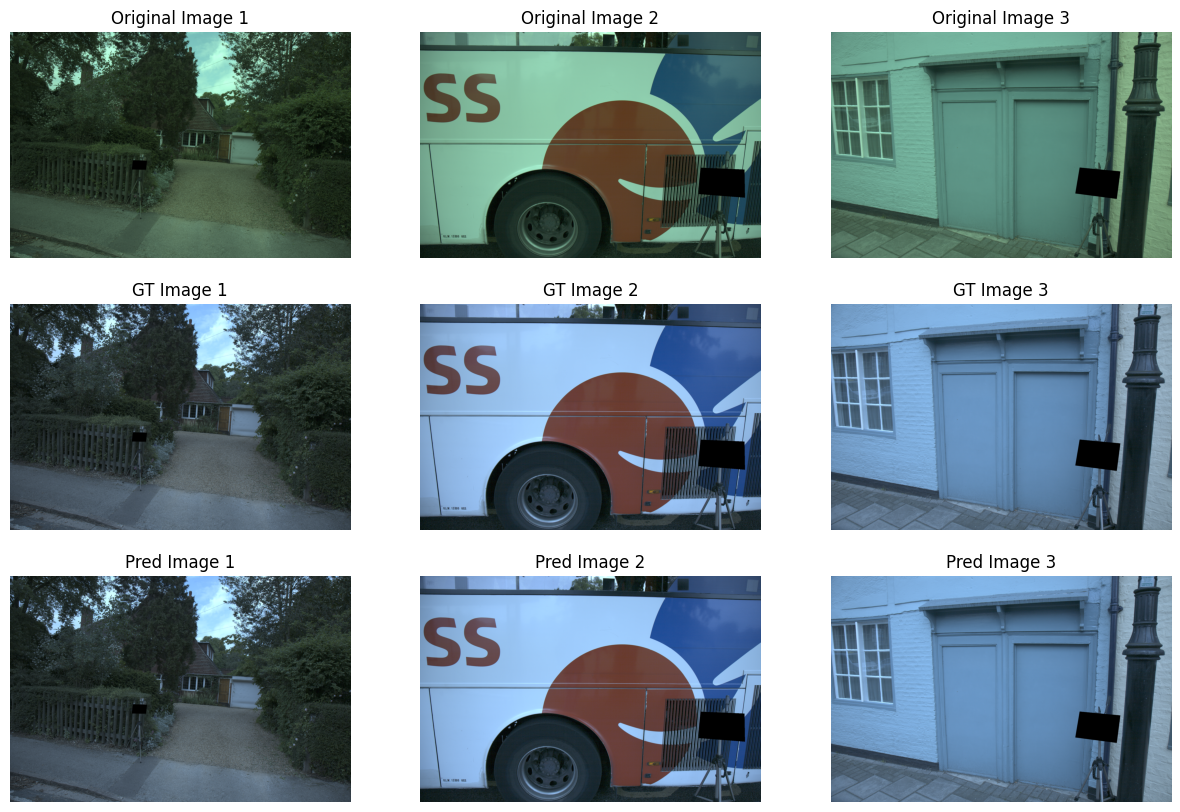

In [12]:
import cv2
import matplotlib.pyplot as plt
from auxiliary.utils import *

scale = 1.2
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i in range(3):
    fn = batch_dict['fn'][i]
    gt_illum = batch_dict['y'][i].numpy()
    pred_illum = ret_dict['y_hat'][i].cpu().numpy()
    
    gt_illum = gt_illum / gt_illum.max()
    pred_illum = pred_illum / pred_illum.max()

    img = load_image_without_mcc(fn, get_mcc_coord(fn))
    img_gt = img / gt_illum
    img_pred = img / pred_illum

    img = scale * linear_to_nonlinear(bgr_to_rgb(normalize(img)))
    img_gt = scale * linear_to_nonlinear(bgr_to_rgb(normalize(img_gt)))
    img_pred = scale * linear_to_nonlinear(bgr_to_rgb(normalize(img_pred)))


    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original Image {i+1}")

    axes[1, i].imshow(img_gt)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"GT Image {i+1}")

    axes[2, i].imshow(img_pred)
    axes[2, i].axis('off')
    axes[2, i].set_title(f"Pred Image {i+1}")


In [6]:
# Import model
network_mod = importlib.import_module(f'models.{cfg.model.name}_{cfg.model.ver}')  # import models/FC4_v1.py
network_class = getattr(network_mod, cfg.model.name)  # get class named "cfg.model.name"
network = network_class(cfg)

path = cfg.load.ckpt_path
ckpt = torch.load(path)
state_dict = ckpt['state_dict']
new_state_dict = {k.replace('net.', ''): v for k, v in state_dict.items()}
network.load_state_dict(new_state_dict)
network.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network.to(device)

images, illums = batch_dict['x'], batch_dict['y']
images, illums = images.to(device), illums.to(device)

with torch.no_grad():
    ret_dict = network(images)

In [7]:
def gamma_correction(image, gamma=2.2):

    if isinstance(image, torch.Tensor):
        return torch.pow(image, 1 / gamma)

    elif isinstance(image, np.ndarray):
        return np.power(image, 1 / gamma)
    
    else:
        raise TypeError("Input should be either torch.Tensor or np.ndarray")    

Normalized illuminants: r=0.44622448086738586, g=1.0, b=0.7871851921081543
Normalized illuminants: r=0.44962307810783386, g=1.0, b=0.7798491716384888
Normalized illuminants: r=0.45794373750686646, g=1.0, b=0.7819313406944275


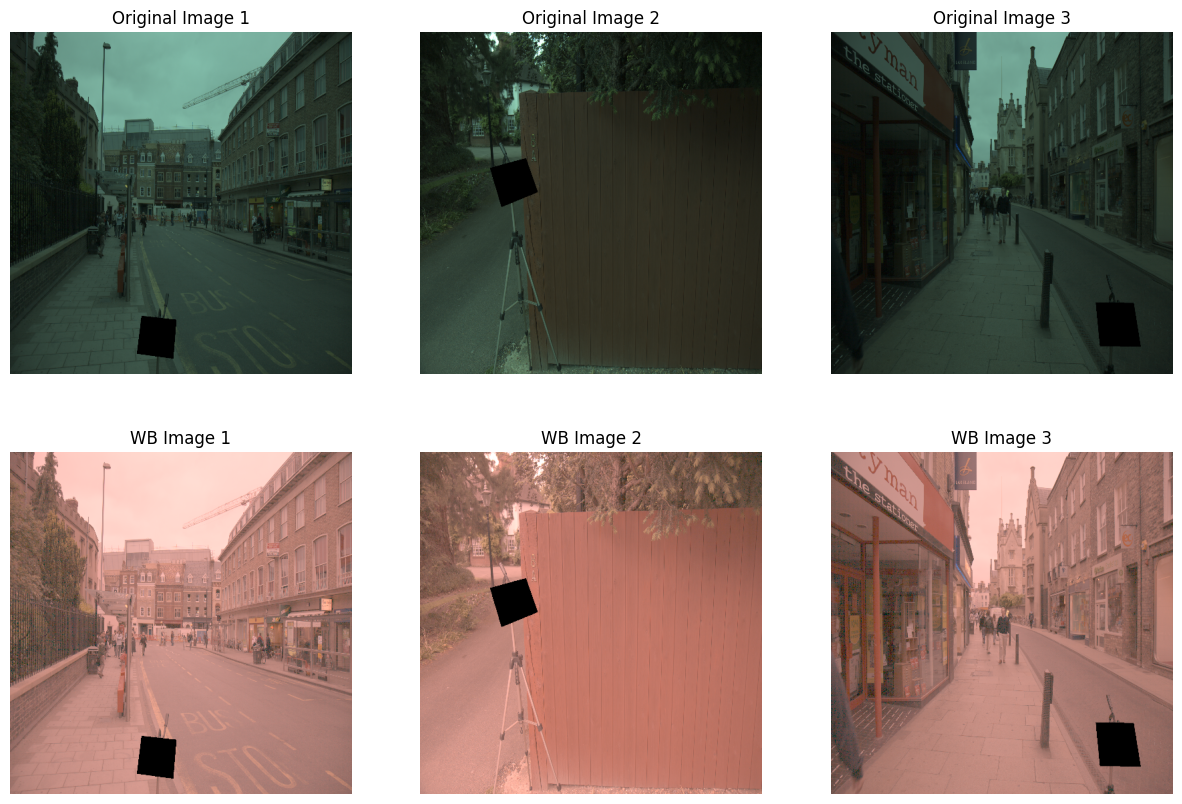

In [22]:
# GT label
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    image = batch_dict['x'][i].permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
    gt_illum = illums[i].cpu().numpy()
    
    # Normalize with green
    gt_illum = gt_illum / np.max(gt_illum)
    r, g, b = gt_illum
    print(f"Normalized illuminants: r={r}, g={g}, b={b}")

    # WB
    wb_image = image.copy()
    wb_image[:, :, 0] /= r
    wb_image[:, :, 0] /= g
    wb_image[:, :, 0] /= b

    wb_image = np.clip(wb_image, 0, 1)
    wb_image = gamma_correction(wb_image)

    # Viusualization
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original Image {i+1}")

    axes[1, i].imshow(wb_image)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"WB Image {i+1}")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6795879775003355].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.2644888063657542].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4466243215732253].


0.43802917 1.0 0.8030986
0.44160077 1.0 0.7988903
0.4516953 1.0 0.7955284


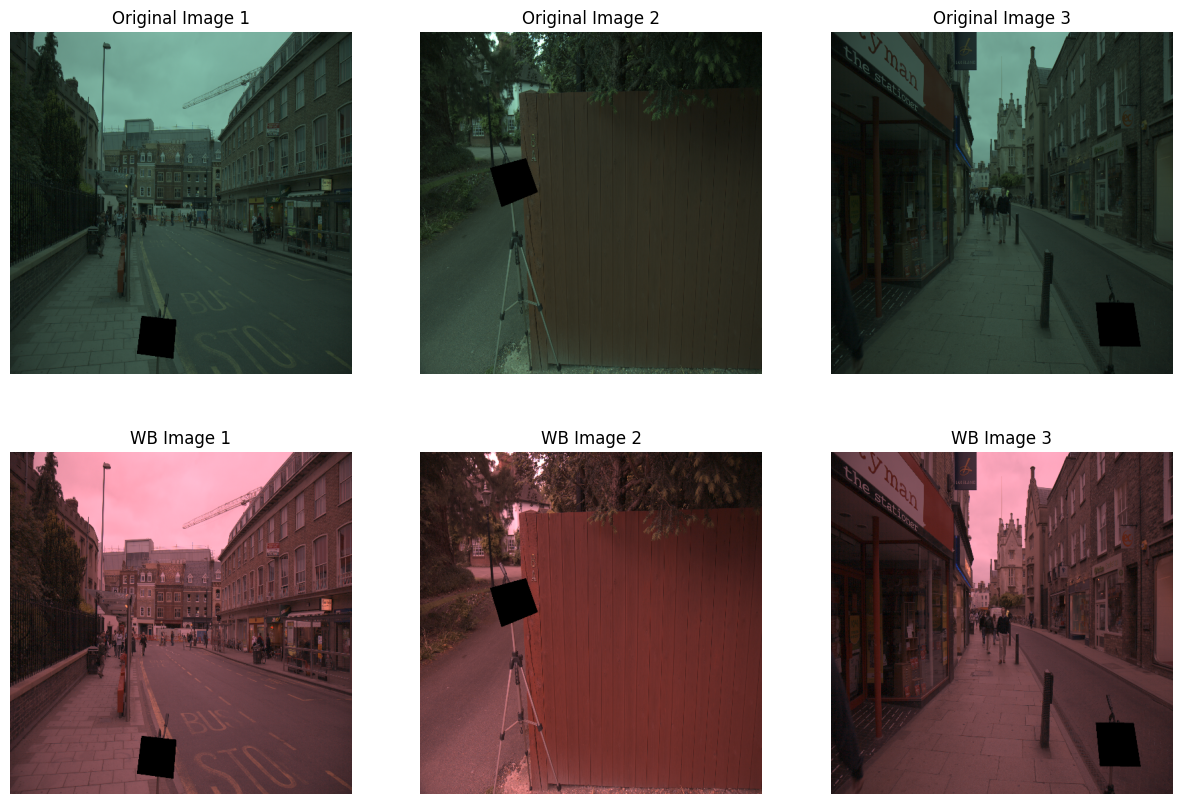

In [19]:
# Inference
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    image = batch_dict['x'][i].permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
    pred_illum = ret_dict['y_hat'][i].cpu().numpy()
    
    r, g, b = pred_illum
    r = r / g
    b = b / g
    g = 1.0

    print(r, g, b)

    # WB
    wb_image = np.clip(image.copy(), 0, 1)
    wb_image[:, :, 0] /= r
    wb_image[:, :, 1] /= g
    wb_image[:, :, 2] /= b

    # print(wb_image)

    # wb_image = np.clip(gamma_correction(wb_image), 0, 1)

    # Viusualization
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original Image {i+1}")

    axes[1, i].imshow(wb_image)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"WB Image {i+1}")

plt.show()

In [9]:
axes

array([<Axes: >, <Axes: >], dtype=object)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3121766052124517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7001186412507225].


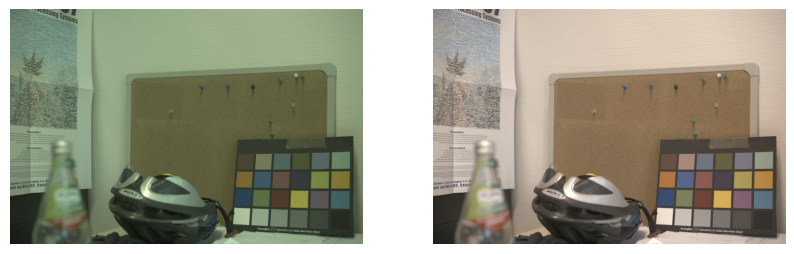

In [10]:
import cv2
import matplotlib.pyplot as plt
from auxiliary.utils import *

path = '8D5U5524.png'
gt_illum = [0.529952, 0.718777, 0.450011]
scale = 5

img = load_image(path)
img_wb = img / gt_illum

img = scale * linear_to_nonlinear(bgr_to_rgb(normalize(img)))
img_wb = scale * linear_to_nonlinear(bgr_to_rgb(normalize(img_wb)))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].axis('off')
axes[1].imshow(img_wb)
axes[1].axis('off')
plt.show()

#hwc_to_chw(linear_to_nonlinear(bgr_to_rgb(normalize(img))))

In [1]:
# 